In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from IPython import display
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [70]:
def my_fvm(): 
    # Domain size and physical variables
    Lx = 1.
    Ly = 1.
    gx = 0.
    gy = 0.
    rho = 1.
    mu = 0.05    # Dynmaic viscocity

    # Tangential velocities
    unorth = 2.
    usouth = 0.
    veast = 0.
    vwest = 0.

    # Numerical variables
    nx = 21           # Number of cells (not nodes!)
    ny = 21
    dt = 0.0004
    nstep = 100
    maxiter = 1000
    maxError = 0.001
    beta = 1.2
    dx = Lx/nx
    dy = Ly/ny
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)

    u = np.zeros((nx+1,ny+2))
    v = np.zeros((nx+2,ny+1))
    p = np.zeros((nx+2,ny+2))
    Ax = np.zeros_like(u)
    Ay = np.zeros_like(v)
    ut = np.zeros_like(u)
    vt = np.zeros_like(v)
    Dx = np.zeros_like(u)
    Dy = np.zeros_like(v)
    tmp1 = np.zeros_like(p)
    tmp2 = np.zeros_like(p)
    uu = np.zeros((nx+1,ny+1))
    vv = np.zeros_like(uu)


    r = np.ones((nx+2, ny+2))*rho

    #start = time.time()
    for step in range(nstep):

        #tangential velocity at boundaries
        u[:,0]=2.*usouth-u[:,1]
        u[:,-1]=2.*unorth-u[:,-2]
        v[0,:]=2.*vwest-v[1,:]
        v[-1,:]=2.*veast-v[-2,:]


        ## Temporary x-velocity MAIN LOOP ##
        for i in range(1,nx):
            for j in range(1,ny+1):
                # Advection matrix
                Ax[i,j] = (0.25/dx*((u[i+1,j]+u[i,j])**2 - (u[i,j]+u[i-1,j])**2) + 
                           0.25/dy*((u[i,j+1]+u[i,j])*(v[i+1,j]+v[i,j]) - 
                                 (u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1])))
                # Diffusion matrix
                Dx[i,j] = mu * ((u[i+1,j]-2*u[i,j]+u[i-1,j])/dx**2 + (u[i,j+1]-2*u[i,j]+u[i,j-1])/dy**2)
                # Temporary velocity
                ut[i,j] = u[i,j] + dt*(-Ax[i,j] + gx + 2*Dx[i,j]/(r[i+1,j]+r[i,j]))

        # Temporary y-velocity MAIN LOOP ##
        for i in range(1,nx+1):
            for j in range(1,ny):
                # Advection matrix
                Ay[i,j] = (0.25/dx*((u[i,j]+u[i,j+1])*(v[i,j]+v[i+1,j]) -
                           (u[i-1,j+1]+u[i-1,j])*(v[i,j]+v[i-1,j])) +
                           0.25/dy*((v[i,j+1]+v[i,j])**2 - (v[i,j]+v[i,j-1])**2))
                # Diffusion matrix
                Dy[i,j] = mu * ((v[i+1,j]-2*v[i,j]+v[i-1,j])/dx**2 + (v[i,j+1]-2*v[i,j]+v[i,j-1])/dy**2)
                # Temporary velocity
                vt[i,j] = v[i,j] + dt*(-Ay[i,j] + gy + 2*Dy[i,j]/(r[i,j+1]+r[i,j]))

        # Source term for pressure equation
        rt = np.copy(r)
        lrg = 1000.
        rt[0,:] = lrg
        rt[-1,:] = lrg
        rt[:,0] = lrg
        rt[:,-1] = lrg

        # Assemble and compute pressure
        for i in range(1,nx+1):
            for j in range(1,ny+1):
                tmp1[i,j] = 1/(2*dt)*((ut[i,j]-ut[i-1,j])/dx + (vt[i,j]-vt[i,j-1])/dy)
                tmp2[i,j] = 1/((1/dx**2)*(1/(rt[i+1,j]+rt[i,j]) + 1/(rt[i,j]+rt[i-1,j])) + 
                                   (1/dy**2)*(1/(rt[i,j+1]+rt[i,j]) + 1/(rt[i,j]+rt[i,j-1])))
        it = 0
        while True:
            pn = np.copy(p)
            it += 1
            for i in range(1,nx+1):
                for j in range(1,ny+1):
                    p[i,j] = (1-beta)*p[i,j] + beta*tmp2[i,j]*((1/dx**2*(p[i+1,j]/(rt[i+1,j]+rt[i,j])+p[i-1,j]/(rt[i,j]+rt[i-1,j])) +
                                                           1/dy**2*(p[i,j+1]/(rt[i,j+1]+rt[i,j])+p[i,j-1]/(rt[i,j]+rt[i,j-1])) - tmp1[i,j]))
            if it%100 == 0:
                print(f'Pressure loop iterations: {it}')
            if np.abs(pn-p).max() < maxError:
                print(f'Pressure convergence achieved in {it} iterations.')
                break
            if it > maxiter:
                print(f'Pressure convergence not achieved. Max iterations reached in pressure loop.')
                break

        # Update velocities
        for i in range(1,nx):
            for j in range(1,ny+1):
                u[i,j] = ut[i,j] - 2*dt/dx*(p[i+1,j]-p[i,j])/(r[i+1,j]+r[i,j])
        for i in range(1,nx+1):
            for j in range(1,ny):
                v[i,j] = vt[i,j] - 2*dt/dy*(p[i,j+1]-p[i,j])/(r[i,j+1]+r[i,j])


        #Plot the velocity field
        uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
        vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
        xx = np.linspace(0,Lx, nx)
        yy = np.linspace(0, Ly, ny)
        #X, Y = np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dy:ny*1j]
        X, Y = np.meshgrid(x, y)
        plt.clf()
        plt.contourf(X, Y, p[1:-1,1:-1].T, cmap=cm.viridis)
        plt.colorbar()
        plt.quiver(X,Y,uu.T, vv.T)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        print(step)
    plt.clf()
    plt.streamplot(X,Y,uu.T,vv.T)
    return u, p
#finish = time.time()
#print(f'Simulation complete. Total time: {finish-start:.2f} seconds')

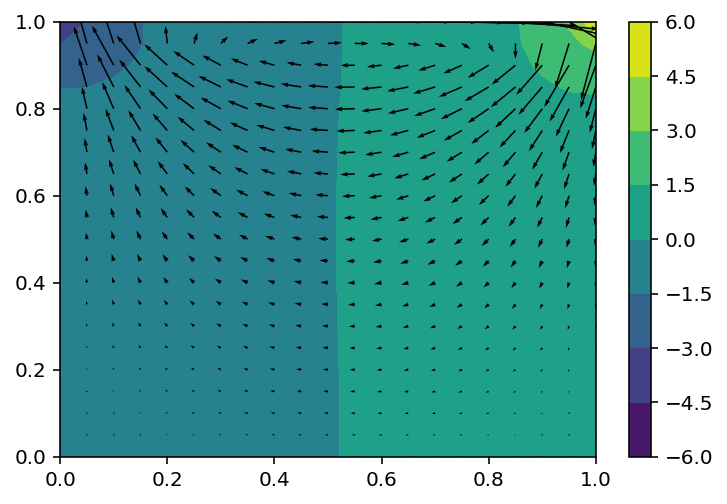

99


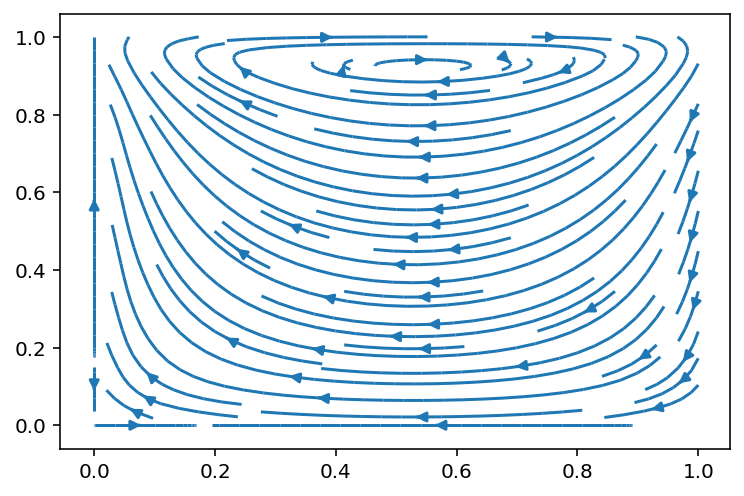

In [71]:
u, p3 = my_fvm()

In [46]:
p[1:-1,1:-1].shape

(21, 21)

In [67]:
def his_fvm():
    #domain size and physical variables
    Lx=1.0
    Ly=1.0
    gx=0.0
    gy=0.0
    rho1=1.0

    #dynamic viscosity
    m0=0.05

    #tangential velocities
    unorth=2.
    usouth=0.
    veast=0.
    vwest=0.

    #Numerical variables
    nx=21
    ny=21
    dt=0.0004
    nstep=100
    maxiter=1000
    maxError=0.001
    beta=1.2

    u=np.zeros((nx+1,ny+2))
    v=np.zeros((nx+2,ny+1))
    p=np.zeros((nx+2,ny+2))

    ut=np.zeros((nx+1,ny+2))
    vt=np.zeros((nx+2,ny+1))

    #temp variables for pressure calculations
    tmp1=np.zeros((nx+2,ny+2))
    tmp2=np.zeros((nx+2,ny+2))

    #velocities at center of grid for plotting
    uu=np.zeros((nx+1,ny+1))
    vv=np.zeros((nx+1,ny+1))
    x = np.linspace(0.,Lx,nx)
    y = np.linspace(0.,Ly,ny)

    #Define the grid
    dx=Lx/(nx) 
    dy=Ly/(ny)


    r=np.ones((nx+2,ny+2))*rho1

    time=0.
    for steps in range(nstep):

        #tangential velocity at boundaries
        u[:,0]=2.*usouth-u[:,1]
        u[:,-1]=2.*unorth-u[:,-2]
        v[0,:]=2.*vwest-v[1,:]
        v[-1,:]=2.*veast-v[-2,:]

        # TEMPORARY u-velocity                               
        for i in range(1,nx):
            for j in range(1,ny+1):
                ut[i,j]=u[i,j]+dt*(-0.25*(((u[i+1,j]+u[i,j])**2-(u[i,j]+\
                    u[i-1,j])**2)/dx+((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                    v[i,j])-(u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1]))/dy)+\
                    m0/(0.5*(r[i+1,j]+r[i,j]))*((u[i+1,j]-2*u[i,j]+u[i-1,j])/dx**2+\
                    (u[i,j+1]-2*u[i,j]+u[i,j-1])/dy**2 )+gx)

        # TEMPORARY v-velocity                               
        for i in range(1,nx+1):
            for j in range(1,ny):
                vt[i,j]=v[i,j]+dt*(-0.25*(((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                    v[i,j])-(u[i-1,j+1]+u[i-1,j])*(v[i,j]+v[i-1,j]))/dx+\
                    ((v[i,j+1]+v[i,j])**2-(v[i,j]+v[i,j-1])**2)/dy)+\
                    m0/(0.5*(r[i,j+1]+r[i,j]))*((v[i+1,j]-2*v[i,j]+v[i-1,j])/dx**2+\
                    (v[i,j+1]-2*v[i,j]+v[i,j-1])/dy**2 )+gy)    

        #Compute source term and the coefficient for p(i,j)
        rt=np.copy(r)
        lrg=1000.
        rt[:,0]=lrg
        rt[:,-1]=lrg
        rt[0,:]=lrg
        rt[-1,:]=lrg

        for i in range(1,nx+1):
            for j in range(1,ny+1):
                tmp1[i,j]= (0.5/dt)*( (ut[i,j]-ut[i-1,j])/dx+(vt[i,j]-vt[i,j-1])/dy)
                tmp2[i,j]=1.0/( (1./dx)*( 1./(dx*(rt[i+1,j]+rt[i,j]))+\
                    1./(dx*(rt[i-1,j]+rt[i,j])))+\
                    (1./dy)*(1./(dy*(rt[i,j+1]+rt[i,j]))+\
                    1./(dy*(rt[i,j-1]+rt[i,j])))) 

        iter=0
        while True:
            pn=np.copy(p)
            iter=iter+1
            for i in range(1,nx+1):
                for j in range(1,ny+1):
                    p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                        (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                        p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                        (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                        p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])
            if np.abs(pn-p).max()<maxError:
                break
            if iter>maxiter:
                break

        #CORRECT THE u-velocity
        for i in range(1,nx):
            for j in range(1,ny+1):
                u[i,j]=ut[i,j]-dt*(2.0/dx)*(p[i+1,j]-p[i,j])/(r[i+1,j]+r[i,j])

        #CORRECT THE v-velocity
        for i in range(1,nx+1):
            for j in range(1,ny):
                v[i,j]=vt[i,j]-dt*(2.0/dy)*(p[i,j+1]-p[i,j])/(r[i,j+1]+r[i,j])

        time=time+dt

        #Plot the velocity field
        uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
        vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
        yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
        plt.clf()
        plt.contourf(X, Y, p[1:-1,1:-1].T, cmap=cm.viridis)
        plt.colorbar()
        plt.quiver(X,Y,uu.T,vv.T)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        print(steps)

    plt.clf()
    plt.streamplot(x,y,uu.T,vv.T)
    return u, p

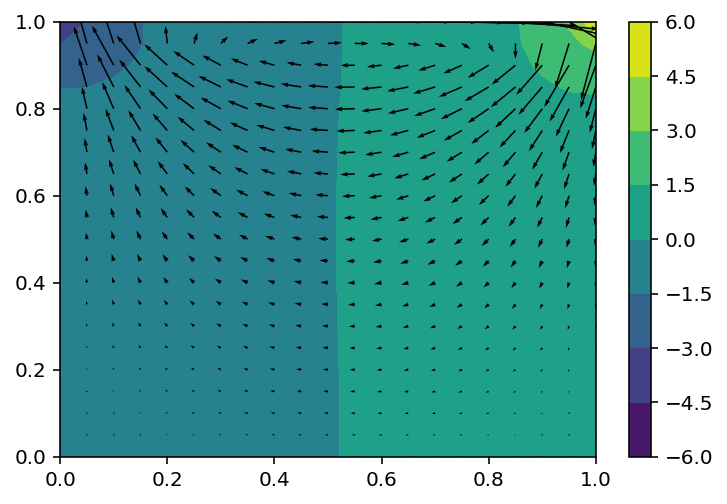

99


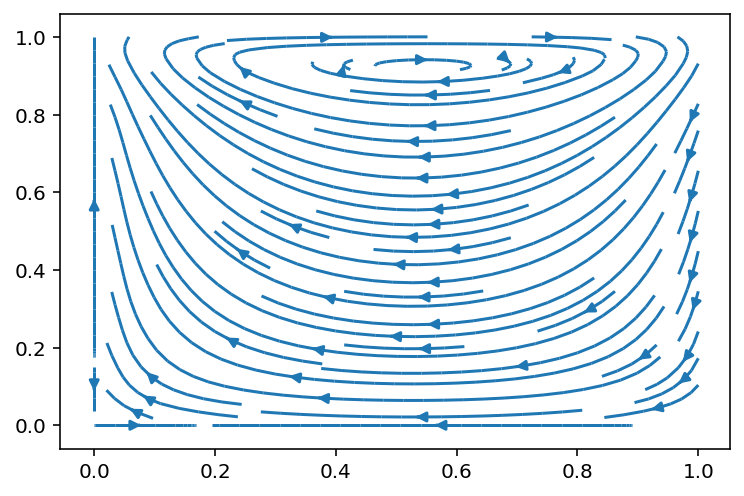

In [68]:
u1, p1 = his_fvm()

In [69]:
xx.shape

(21,)

In [62]:
p[10]

array([ 0.        , -0.09989069, -0.09979157, -0.10051327, -0.10209085,
       -0.10457641, -0.10805197, -0.11262963, -0.11845158, -0.12568908,
       -0.13453826, -0.14521005, -0.15791022, -0.17280456, -0.18996176,
       -0.20926825, -0.23031292, -0.25223355, -0.27345679, -0.29117968,
       -0.301088  , -0.30017505,  0.        ])

In [65]:
p3[10]

array([ 0.        , -0.09989069, -0.09979157, -0.10051327, -0.10209085,
       -0.10457641, -0.10805197, -0.11262963, -0.11845158, -0.12568908,
       -0.13453826, -0.14521005, -0.15791022, -0.17280456, -0.18996176,
       -0.20926825, -0.23031292, -0.25223355, -0.27345679, -0.29117968,
       -0.301088  , -0.30017505,  0.        ])

In [66]:
np.allclose(p, p3)

True